## Setup

In [45]:
import numpy as np

# Left and right boundaries
xl, xr = 0, 1

# Final time
T = 1.0

# External forcing
def f(x, t):
    return (np.pi ** 2 - 1) * np.exp(-t) * np.sin(np.pi * x)

# Define parent grid [-1 <= ksi <= 1] basis functions and derivatives
def phi_hat_1(ksi): return (1 - ksi) / 2

def phi_hat_2(ksi): return (1 + ksi) / 2

def assembly(N):
    # Total number of elements
    N_e = N - 1
    
    # Grid spacing
    h = (xr - xl) / N_e
    # Uniform grid
    x = np.linspace(xl, xr, N)

    # Map elements to node numbers (iee in lecture slides)
    ele_nodes = np.zeros((N_e, 2), dtype=int)
    # Create connectivity map
    for i in range(N - 1):
        ele_nodes[i][0] = i
        ele_nodes[i][1] = i + 1

    # Initialization
    # Global stiffness
    K = np.zeros((N, N))

    # Assemble K matrix
    # For each element
    for k in range(N_e):
        # Local element stiffness for 2x2
        K_local = (1 / h) * np.array([[1, -1], 
                                      [-1, 1]])
        
        # Finite element assembly
        for l in range(2):
            for m in range(2):
                global_node_1 = ele_nodes[k][l]
                global_node_2 = ele_nodes[k][m]
                K[global_node_1][global_node_2] += K_local[l][m]

    # Assemble mass matrix, M
    M = np.zeros((N, N))
    for k in range(N_e):
        M_local = (h / 6) * np.array([[2, 1],
                                    [1, 2]])
        node1, node2 = ele_nodes[k]
        M[node1, node1] += M_local[0][0]
        M[node1, node2] += M_local[0][1]
        M[node2, node1] += M_local[1][0]
        M[node2, node2] += M_local[1][1]

    # The heat transfer problem does not have natural boundary conditions
    # Dirichlet boundary conditions (only let and right nodes)
    for i in [0, N - 1]:
        # Zero out columns and rows of K and M
        K[i, :] = 0.0
        K[:, i] = 0.0
        M[i, :] = 0.0
        M[:, i] = 0.0
        # Set diagonal (i.e. first and last elements of matrix) to 1
        K[i][i] = 1.0
        M[i][i] = 1.0
    
    return x, h, K, M, ele_nodes
        
# Helper function to assemble F matrix at a given time
def assemble_F(N, t, x, ele_nodes, h):
    # 2nd order Gaussian quadrature
    gauss_weights = np.array([1, 1])
    gauss_quad = np.array([-1 / np.sqrt(3), 1 / np.sqrt(3)])
    
    # Global right hand side (RHS)
    F = np.zeros((N, 1))
    for k in range(N - 1):
        # Local element RHS
        F_local = np.zeros((2, 1))
        
        # Left node of this element
        xi = x[ele_nodes[k, 0]]
        
        for g in range(2):  # 2 local nodes per 1D element
            # Solve with quadrature
            ksi = gauss_quad[g]
            w = gauss_weights[g]
            x_g = (ksi + 1) * h / 2 + xi
            f_g = f(x_g, t)
            
            phi1 = phi_hat_1(ksi)
            phi2 = phi_hat_2(ksi)
            
            F_local[0] += w * f_g * phi1 * h/2
            F_local[1] += w * f_g * phi2 * h/2
        
        # Finite element assembly
        for l in range(2):
            global_node_1 = ele_nodes[k][l]
            F[global_node_1] += F_local[l]
    
    # Dirichlet boundary conditions
    F[0] = 0.0
    F[-1] = 0.0
    return F



## Forward Euler

In [65]:
import matplotlib.pyplot as plt
    

# Analytical solution for comparison
def analytical(x, t):
    return np.exp(-t) * np.sin(np.pi * x)

xx = np.linspace(xl, xr, 1000)

# Time integration using Forward Euler, for a given time step
def fwd_euler(N, dt, dt_str):
    x, h, K, M, ele_nodes = assembly(N)
    # Set up initial conditions for numerical solution
    U = np.sin(np.pi * x).reshape(N, 1)
    U[0] = 0.0
    U[-1] = 0.0
    
    Nt = int(np.ceil(T / dt))
    for n in range(Nt):
        t = n * dt
        # See update equation in PDF
        Ft = assemble_F(N, t, x, ele_nodes, h)
        rhs = Ft - (K @ U)
        U = U + dt * np.linalg.solve(M, rhs)
        # Keep boundary conditions
        U[0] = 0.0
        U[-1] = 0.0
    
    plt.figure()
    plt.plot(x, U, 'r-', label=f'Numerical Solution')
    plt.plot(xx, analytical(xx, 1), 'k--', label=f'Analytical Solution')
    plt.xlabel('x')
    plt.ylabel('U(x, t)')
    plt.title(f'Forward Euler (N={N}, dt={dt_str})')
    plt.legend()
    plt.grid()
    plt.show()

## Backward Euler

In [113]:
import matplotlib.pyplot as plt
    
# Time integration using Backward Euler, for a given time step
def bwd_euler(N, dt, dt_str):
    x, h, K, M, ele_nodes = assembly(N)
    # Set up initial conditions for numerical solution
    U = np.sin(np.pi * x).reshape(N, 1)
    U[0] = 0.0
    U[-1] = 0.0
    
    # A matrix
    A = M + dt * K
    
    Nt = int(np.ceil(T / dt))
    for n in range(Nt):
        tnp1 = (n + 1) * dt
        # See update equation in PDF
        Ftp1 = assemble_F(N, tnp1, x, ele_nodes, h)
        # b vector
        b = dt * Ftp1 + M @ U
        U = np.linalg.solve(A, b)
        # Keep boundary conditions
        U[0] = 0.0
        U[-1] = 0.0
    
    plt.figure()
    plt.plot(x, U, 'c-', label=f'Numerical Solution')
    plt.plot(xx, analytical(xx, 1), 'k--', label=f'Analytical Solution')
    plt.xlabel('x')
    plt.ylabel('U(x, t)')
    plt.title(f'Backward Euler (N={N}, dt={dt_str})')
    plt.legend()
    plt.grid()
    plt.show()

## Plotting

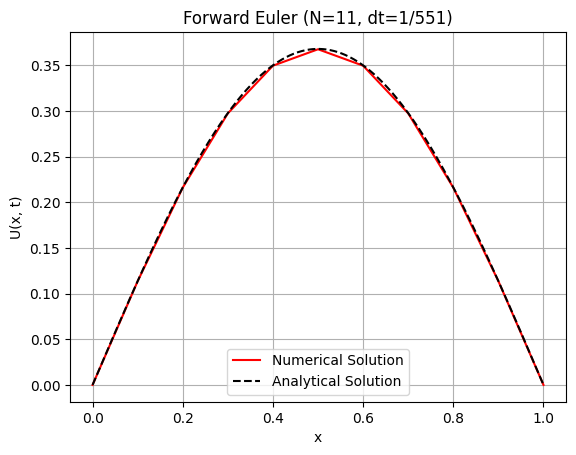

In [67]:
fwd_euler(N=11, dt=1/551, dt_str='1/551')

For dt = 1/551, the numerical solution is stable and matches the analytical solution well.

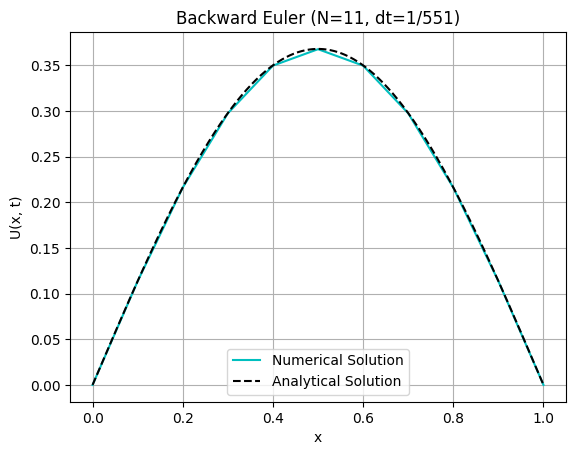

In [114]:
bwd_euler(N=11, dt=1/551, dt_str='1/551')

For this N and dt, the backward Euler numerical solution is also accurate and stable.

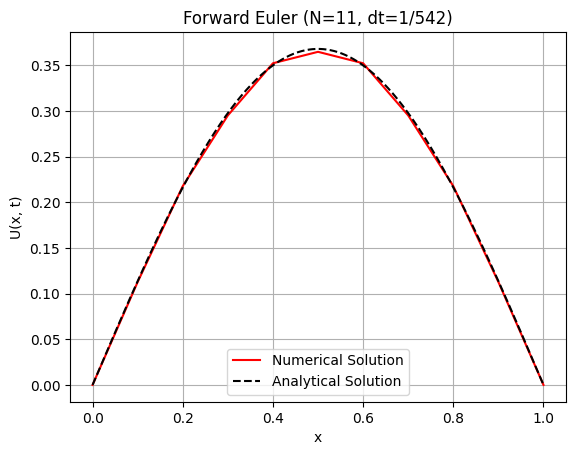

In [78]:
fwd_euler(N=11, dt=1/542, dt_str='1/542')

For dt=1/542, the numerical solution is still stable.

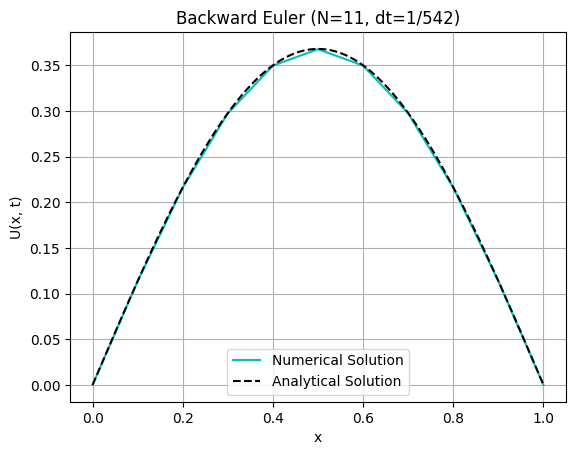

In [115]:
bwd_euler(N=11, dt=1/542, dt_str='1/542')

Still stable for backward Euler.

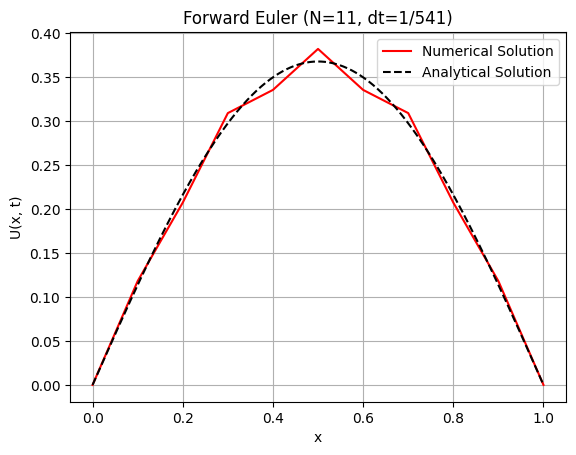

In [ ]:
fwd_euler(N=11, dt=1/541, dt_str='1/541')

For dt=1/541, the instability of the numerical solution begins to show in the form of wiggles.

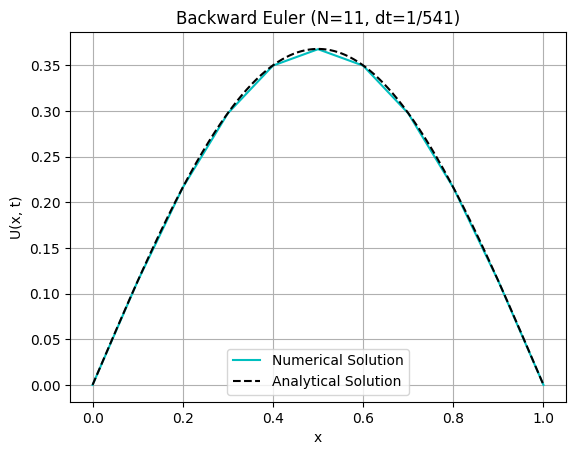

In [116]:
bwd_euler(N=11, dt=1/541, dt_str='1/541')

Unlike the forward Euler numerical solution, the backward Euler numerical solution is still stable and accurate, with no wiggles.

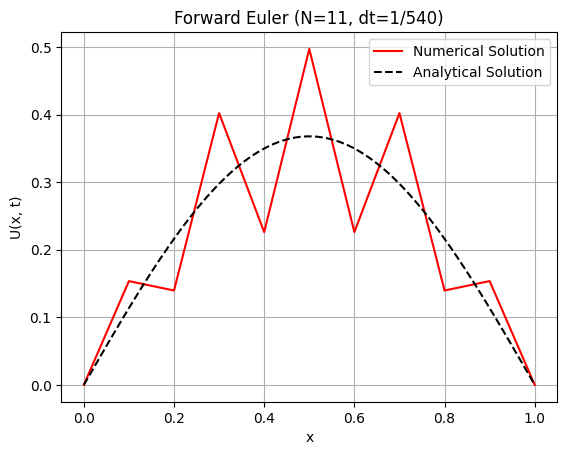

In [80]:
fwd_euler(N=11, dt=1/540, dt_str='1/540')

For dt=1/540, the numerical solution shows strong oscillations.

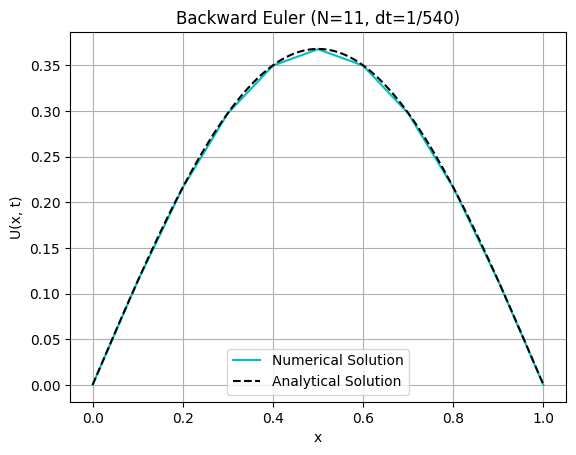

In [117]:
bwd_euler(N=11, dt=1/540, dt_str='1/540')

Still stable and accurate.

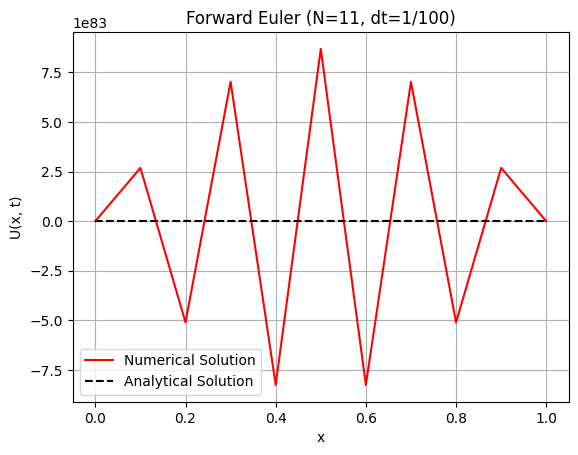

In [96]:
fwd_euler(N=11, dt=1/100, dt_str='1/100')

For dt=1/100, the numerical solution has completely exploded, and is clearly unstable.

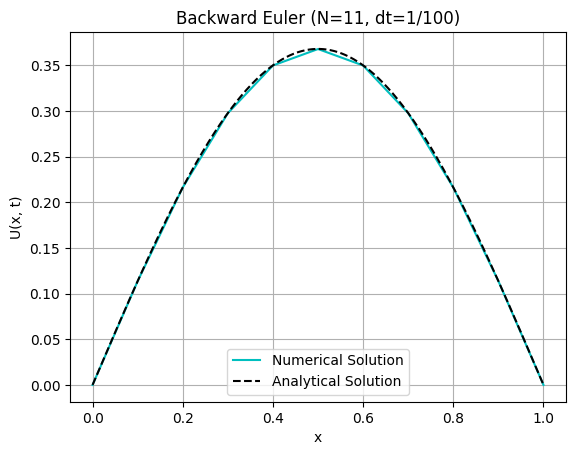

In [118]:
bwd_euler(N=11, dt=1/100, dt_str='1/100')

Still stable and accurate.

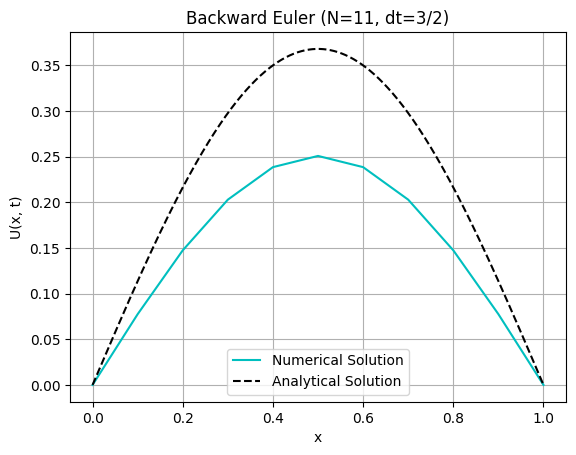

In [157]:
bwd_euler(N=11, dt=1.5, dt_str='3/2')

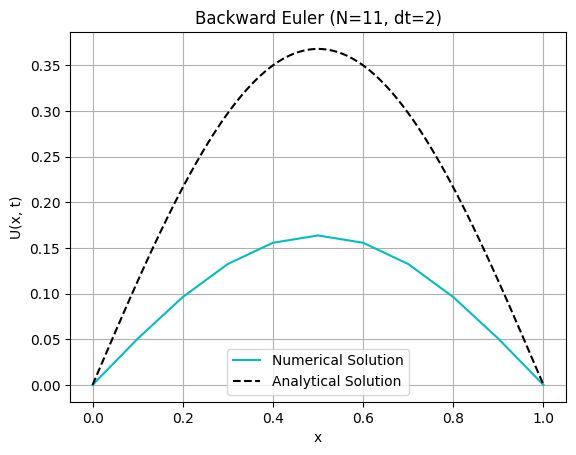

In [160]:
bwd_euler(N=11, dt=2, dt_str='2')

When the time step is equal to or greater than the spatial step size, the numerical solution for Backward Euler becomes diffusive, causing the amplitude of the numerical solution to dampen. Despite this, backward Euler time integration is unconditionally stable, so it doesn't blow up regardless of the time step.

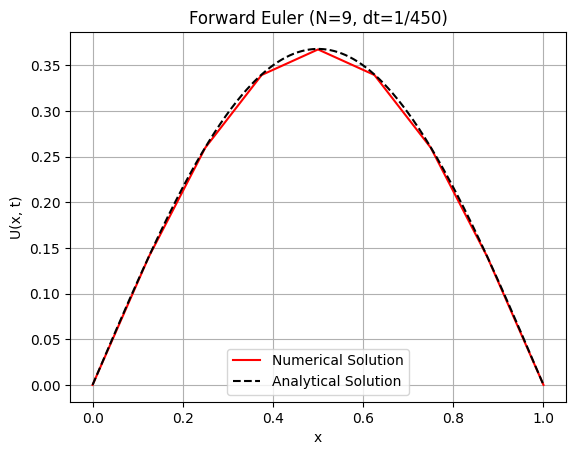

In [146]:
fwd_euler(N=9, dt=1/450, dt_str='1/450')

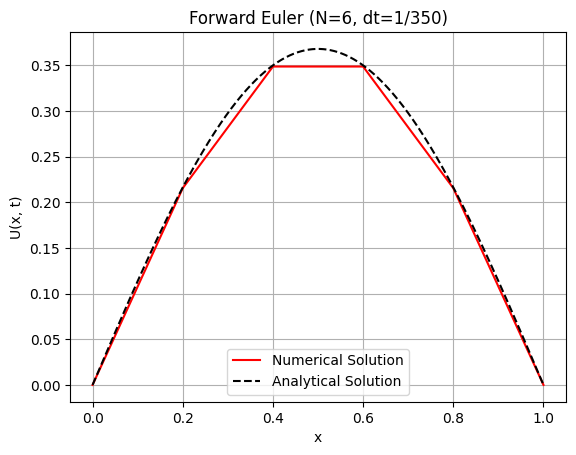

In [147]:
fwd_euler(N=6, dt=1/350, dt_str='1/350')

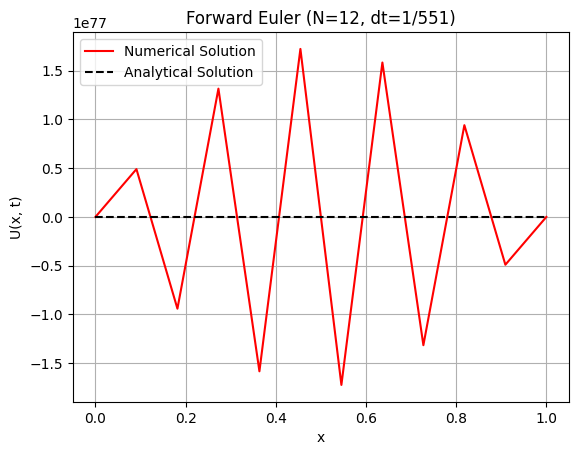

In [150]:
fwd_euler(N=12, dt=1/551, dt_str='1/551')

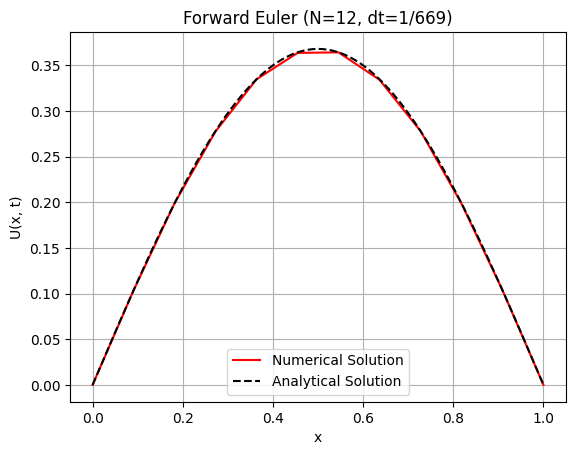

In [155]:
fwd_euler(N=12, dt=1/669, dt_str='1/669')

As N increased to 12, the original dt of 1/551, was no longer sufficient for a stable solution.

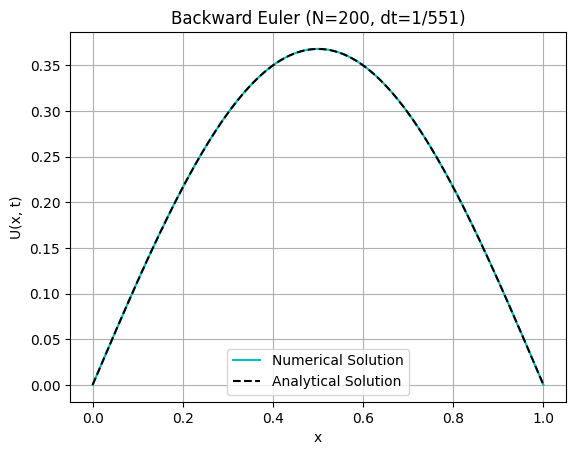

In [167]:
bwd_euler(N=200, dt=1/551, dt_str='1/551')

Of course, the numerical solution for backward Euler is still stable.

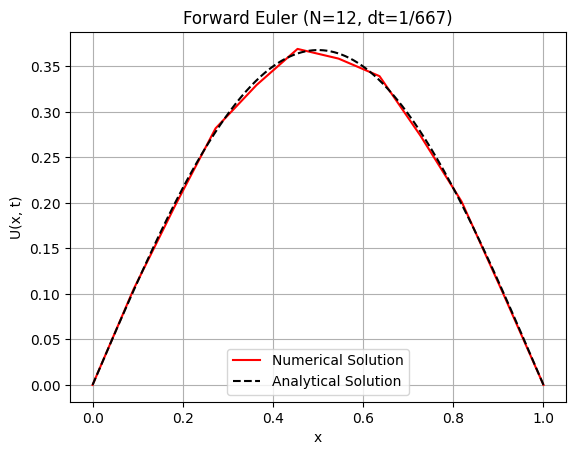

In [108]:
fwd_euler(N=12, dt=1/667, dt_str='1/667')

As N increases, this causes the grid spacing, h, to decrease. In order to maintain stability, dt must also decrease accordingly. This shows that the Forward Euler scheme is conditionally stable.